## VQLS Resrouce Estimation

In this notebook, we transpile the VQLS circuit to a real quantum hardware and estimate the quantum resource required to run it.

### Import circuit

In [1]:
from qiskit import qpy
 
with open('vqls.qpy', 'rb') as handle:
    qc = qpy.load(handle)
vqls_cir = qc[0]
vqls_cir.draw("mpl", fold=60)

In [2]:
print("VQLS Circuit depth =", vqls_cir.depth())
print("VQLS gate counts:", vqls_cir.count_ops())

VQLS Circuit depth = 2613
VQLS gate counts: OrderedDict({'cx': 1214, 'p': 655, 'u': 479, 't': 460, 'tdg': 345, 'h': 230, 'ccx': 22})


### Import IBM Account

In [3]:
from qiskit_ibm_runtime import Session, QiskitRuntimeService, Options

# Save your credentials on disk.
# QiskitRuntimeService.delete_account()
# QiskitRuntimeService.save_account(channel='ibm_quantum', instance='ibm-q/open/main', token='<IBMQ_token>')

service = QiskitRuntimeService()
backend = service.get_backend('ibm_sherbrooke')

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_18336\2139227930.py:8: DeprecationWarning: The get_backend() method is deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use backend() instead.
  backend = service.get_backend('ibm_sherbrooke')


Or you can import a fake backend with past calibration data.

In [4]:
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke

backend = FakeSherbrooke()

## Transpile VQLS circuit

In [93]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pass_manager = generate_preset_pass_manager(
    backend=backend,
    optimization_level=3,
    # layout_method='sabre',
    # routing_method='sabre',
    seed_transpiler=0
)
ansatz_ibm = pass_manager.run(vqls_cir)

In [94]:
for task in pass_manager.init.to_flow_controller().tasks:
        print(" -", type(task).__name__)

 - UnitarySynthesis
 - HighLevelSynthesis
 - BasisTranslator
 - ElidePermutations
 - RemoveDiagonalGatesBeforeMeasure
 - InverseCancellation
 - CommutativeCancellation


In [95]:
print("Transpiled VQLS circuit depth on real backend ibm_sherbrooke =", ansatz_ibm.depth())
print("Transpiled VQLS gate counts on real backend ibm_sherbrooke:", ansatz_ibm.count_ops())

Transpiled VQLS circuit depth on real backend ibm_sherbrooke = 7772
Transpiled VQLS gate counts on real backend ibm_sherbrooke: OrderedDict({'rz': 6556, 'sx': 4001, 'ecr': 1846, 'x': 198})


In [96]:
print("Transpiled VQLS circuit depth on fake backend fake_sherbrooke =", ansatz_ibm.depth())
print("Transpiled VQLS gate counts on fake backend fake_sherbrooke:", ansatz_ibm.count_ops())

Transpiled VQLS circuit depth on fake backend fake_sherbrooke = 7772
Transpiled VQLS gate counts on fake backend fake_sherbrooke: OrderedDict({'rz': 6556, 'sx': 4001, 'ecr': 1846, 'x': 198})


In [97]:
import numpy as np
from qiskit import schedule

sched = schedule(ansatz_ibm, backend)
print("Transpiled VQLS circuit physical runtime = {:.2f} micro seconds".format(sched.duration*backend.dt*1e6))

t2s = [backend.qubit_properties(n).t2 for n in range(backend.num_qubits)]
print("The averaged coherence time on ibm_sherbrooke T2 = {:.2f} micro seconds".format(np.mean(t2s)*1e6))

Transpiled VQLS circuit physical runtime = 1095.74 micro seconds
The averaged coherence time on ibm_sherbrooke T2 = 188.19 micro seconds


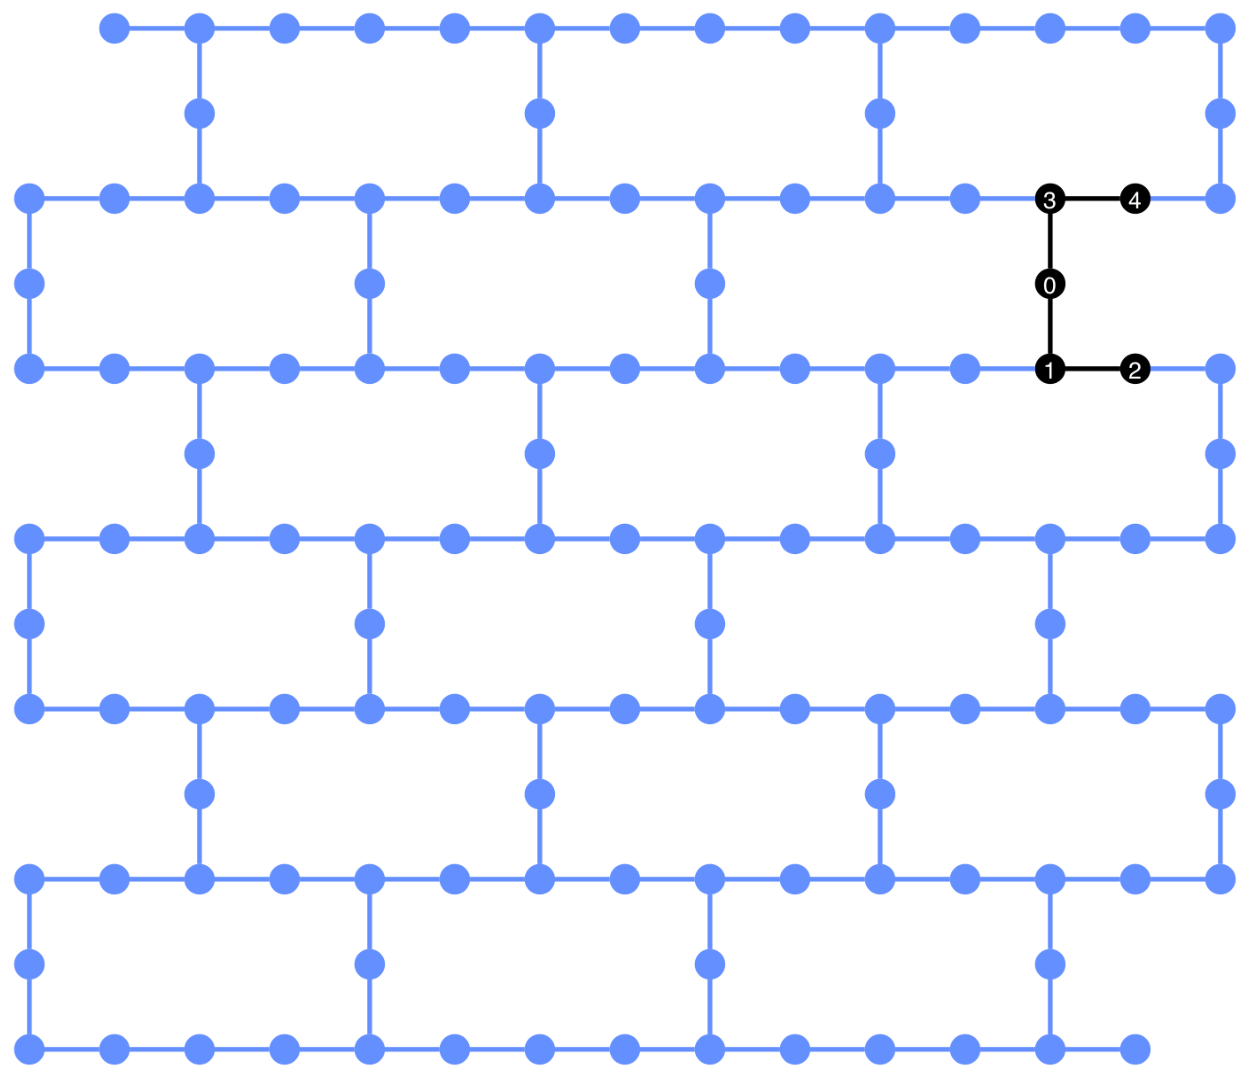

In [ ]:
from qiskit.visualization import plot_circuit_layout
display(plot_circuit_layout(ansatz_ibm, backend))

# Pytket compilation

In [5]:
from pytket.architecture import Architecture
from pytket.passes import DecomposeArbitrarilyControlledGates, KAKDecomposition, FullPeepholeOptimise, CXMappingPass, SequencePass, RepeatWithMetricPass, AutoRebase
from pytket.placement import NoiseAwarePlacement
from pytket.circuit import OpType
from pytket.utils.stats import gate_counts
from pytket.extensions.qiskit import qiskit_to_tk, tk_to_qiskit


In [6]:
# Using original circuit
tket_circ = qiskit_to_tk(vqls_cir)

# Using Qiskit optimized circuit
#tket_circ = qiskit_to_tk(ansatz_ibm)

print(gate_counts(tket_circ))
#render_circuit_jupyter(tket_circ)

Counter({<OpType.CX: 45>: 1214, <OpType.U1: 39>: 655, <OpType.U3: 37>: 479, <OpType.T: 27>: 460, <OpType.Tdg: 28>: 345, <OpType.H: 33>: 230, <OpType.CCX: 61>: 22})


In [7]:
edge_list = list(backend.coupling_map.graph.edge_list())

def cost(circ):
  num_qubits = np.array([x.args for x in circ])
  _, counts = np.unique(num_qubits, return_counts=True)
  res = counts[0] + 100*counts[1]
  return res

architecture = Architecture(edge_list)
cx_pass = CXMappingPass(architecture, NoiseAwarePlacement(architecture))

passes = SequencePass([DecomposeArbitrarilyControlledGates(), KAKDecomposition(), FullPeepholeOptimise(), cx_pass])
repeat_cost_passes = RepeatWithMetricPass(passes, cost)
passes.apply(tket_circ)

gates = {OpType.U1, OpType.U2, OpType.U3, OpType.noop, OpType.CX}

rebase = AutoRebase(gates)
rebase.apply(tket_circ)
print(gate_counts(tket_circ))

#render_circuit_jupyter(tket_circ)

Counter({<OpType.CX: 45>: 1795, <OpType.U3: 37>: 1285})


In [8]:
circ = tk_to_qiskit(tket_circ)
circ.draw("mpl", fold=60)

ValueError: Image size of 5209x386233 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 5209.06x386233 with 1 Axes>

In [9]:
print("VQLS Circuit depth =", circ.depth())
print("VQLS gate counts:", circ.count_ops())

VQLS Circuit depth = 2740
VQLS gate counts: OrderedDict({'cx': 1795, 'u': 1285})


## Transpile VQLS circuit after Pytket compilation

In [10]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pass_manager = generate_preset_pass_manager(
    backend=backend,
    optimization_level=3,
    # layout_method='sabre',
    # routing_method='sabre',
    seed_transpiler=0
)
ansatz_ibm = pass_manager.run(circ)

In [11]:
for task in pass_manager.init.to_flow_controller().tasks:
        print(" -", type(task).__name__)

 - UnitarySynthesis
 - HighLevelSynthesis
 - BasisTranslator
 - ElidePermutations
 - RemoveDiagonalGatesBeforeMeasure
 - InverseCancellation
 - CommutativeCancellation


In [12]:
print("Transpiled VQLS circuit depth on real backend ibm_sherbrooke =", ansatz_ibm.depth())
print("Transpiled VQLS gate counts on real backend ibm_sherbrooke:", ansatz_ibm.count_ops())

Transpiled VQLS circuit depth on real backend ibm_sherbrooke = 6393
Transpiled VQLS gate counts on real backend ibm_sherbrooke: OrderedDict({'rz': 5118, 'sx': 3078, 'ecr': 1434, 'x': 243})


In [13]:
print("Transpiled VQLS circuit depth on fake backend fake_sherbrooke =", ansatz_ibm.depth())
print("Transpiled VQLS gate counts on fake backend fake_sherbrooke:", ansatz_ibm.count_ops())

Transpiled VQLS circuit depth on fake backend fake_sherbrooke = 6393
Transpiled VQLS gate counts on fake backend fake_sherbrooke: OrderedDict({'rz': 5118, 'sx': 3078, 'ecr': 1434, 'x': 243})


In [14]:
import numpy as np
from qiskit import schedule

sched = schedule(ansatz_ibm, backend)
print("Transpiled VQLS circuit physical runtime = {:.2f} micro seconds".format(sched.duration*backend.dt*1e6))

t2s = [backend.qubit_properties(n).t2 for n in range(backend.num_qubits)]
print("The averaged coherence time on ibm_sherbrooke T2 = {:.2f} micro seconds".format(np.mean(t2s)*1e6))

Transpiled VQLS circuit physical runtime = 886.12 micro seconds
The averaged coherence time on ibm_sherbrooke T2 = 188.19 micro seconds


## Software info

In [17]:
import qiskit
import qiskit_ibm_runtime
import pytket

print(f'Qiskit: {qiskit.__version__}')
print(f'Qiskit IBM Runtime: {qiskit_ibm_runtime.__version__}')
print(f'Pytket: {pytket.__version__}') 

Qiskit: 1.1.1
Qiskit IBM Runtime: 0.24.1
Pytket: 1.29.2
